## 3dshapes exploration

* the images are 64x64, not 224x224 as the pretrained ResNet expects. 
* 480.000 images: ground truth factors: shape[4], scale[8], orientation[15], floor colour[10], wall colour[10], object colour[10]

The notebook is structured as follows: first, there is a visual exploration of the dataset using the code from the repo. Second, there is an initial stab at creating captions for the images in the dataset. Third, there is an exploration of embedding these images with ResNet50 used in the main experiment. At the end, there are some misc notes and some exploration of the grammatical properties of the MS COCO captions.

In [1]:
# try loading the data
# code below from: 
# https://github.com/deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb


from matplotlib import pyplot as plt
import numpy as np
import h5py
from nltk import CFG
from nltk.parse.generate import generate
import json
import nltk

In [3]:
# load dataset
dataset = h5py.File('../../../../../mSc_thesis/mSc-thesis/data/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [ ]:
# convert the image file to a npy file, for significantly faster reading speed
images_np = np.array(images)
# with open("../../mSc-thesis/data/3dshapes_np.npy", "wb") as f:
#     np.save(f, images_np)

In [3]:
# len(labels)
# explore unique values for each dimension for creating keys in the grammar below
np.unique(labels[:, 5])

array([-30.        , -25.71428571, -21.42857143, -17.14285714,
       -12.85714286,  -8.57142857,  -4.28571429,   0.        ,
         4.28571429,   8.57142857,  12.85714286,  17.14285714,
        21.42857143,  25.71428571,  30.        ])

In [4]:
type(dataset["images"])

h5py._hl.dataset.Dataset

In [7]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1

  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
#     print(factor, name)
#     print(indices)
#     print(base)
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
    
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  print("Indices ", indices)
#   indices = np.arange(10, 35)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
#   print("factor shape ", factors.shape)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
#   print("Factor before get_index ", factors)
  indices = get_index(factors)
#   print("retrieved indices ", indices)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

In [5]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
  plt.savefig("3dshapes_example.png", dpi=500)

150000


numpy.ndarray

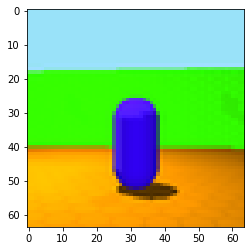

In [146]:
import torch 
plt.imshow(images[int(sanity_check[0])], cmap='Greys_r', interpolation='nearest')
sanity_check = torch.load("../../mSc-thesis/code/src/pretrain_img_IDs_flat_3dshapes.pt")
print(len(sanity_check))
type(images[int(sanity_check[0])])

Indices  [118308 235786 295696 283310 292170 225572 479565 226657 244413  12045
 175440  49463 464392  87752   5121 352497  80000 273441 294060 155727
 135704 107079 143360 430518  30215]


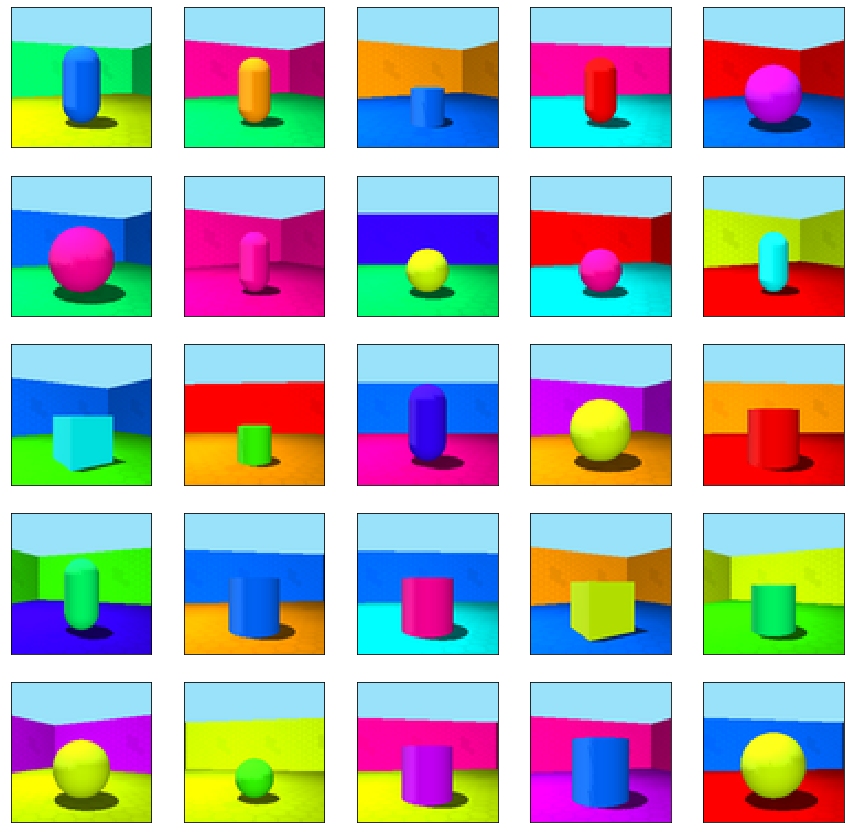

In [12]:
# random images
batch_size = 25
img_batch = sample_random_batch(batch_size)

show_images_grid(img_batch)

# labels : 175440  49463 464392  87752   5121

In [15]:
from datetime import datetime

In [ ]:
# systematically explore the variations:
# hue : 0=red, 1=orange, 2=yellow, 3=light green, 4=dark green, 5=cyan, 6=medium blue, 7= dark blue, 8=purple, 9=pink 
# shape: 0=cube, 1=cylinder, 2=sphere , 3=pill, 4=cube
# scale: 0=small, --> 7=huge
# orientation: orientation of room (rotation, visibility of corner)
t1 = datetime.now()

batch_size = 150000
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 3# first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)
t2 = datetime.now()

print("time taken ", t2-t1)
# sample_batch(batch_size, fixed_factor, fixed_factor_value)
# show_images_grid(img_batch)

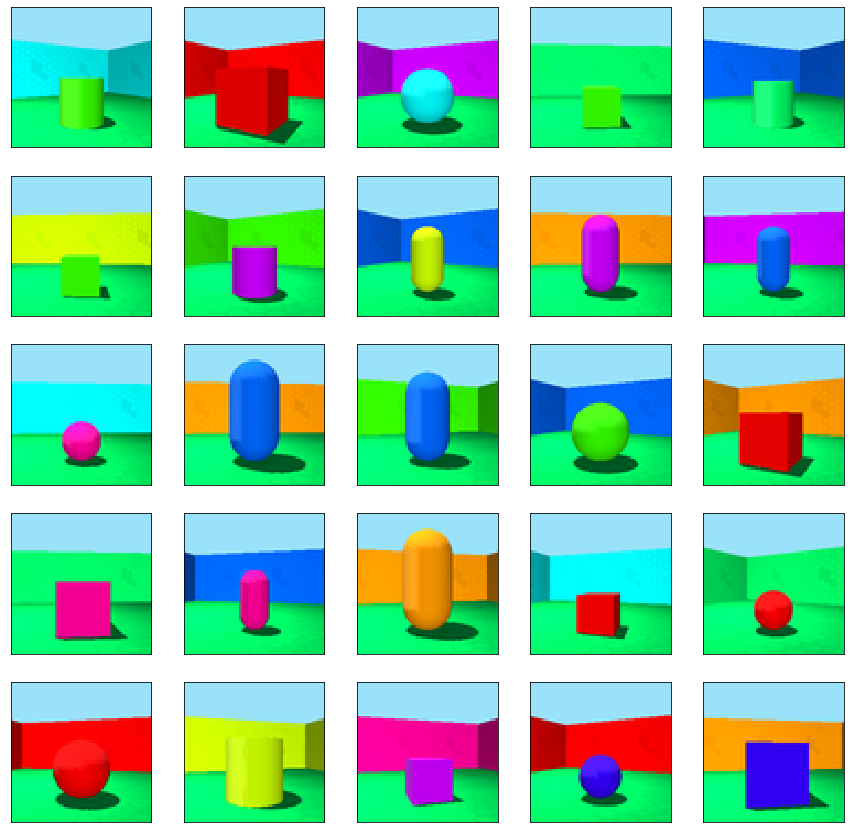

In [134]:
batch_size = 25
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 4# first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)
# sample_batch(batch_size, fixed_factor, fixed_factor_value)
show_images_grid(img_batch)

In [55]:
labels.shape

(480000, 6)

In [2]:
with open("../../mSc-thesis/data/3dshapes_captions_fixed.json", "r") as fp:
    long_labels = json.load(fp)
with open("../../mSc-thesis/data/3dshapes_captions_short.json", "r") as fp:
    short_labels = json.load(fp)   

## Create an initial grammar and loop for generating captions

The labels have the shape (480000, 6), each entry being a list of values for each of the 6 dimensions. The number of unique values for each of the dimensions matches the numbers listed in `_NUM_VALUES_PER_FACTOR`. To get the correct vocabulary for each particular value, we can just create a dictionary indexed with the unique values with lists of correct production rules for each situation. For instance:

In [3]:
dict_factor_rules = {
    "floor_hue": {
    0: ["FLOOR_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["FLOOR_HUE -> 'orange'"],
    0.2: ["FLOOR_HUE -> 'yellow'"],
    0.30000000000000004: ["FLOOR_HUE -> 'green'"],
    0.4: ["FLOOR_HUE -> 'light green'"],
    0.5: ["FLOOR_HUE -> 'cyan'"],
    0.6000000000000001: ["FLOOR_HUE -> 'medium blue'"],
    0.7000000000000001: ["FLOOR_HUE -> 'dark blue'"],
    0.8: ["FLOOR_HUE -> 'purple'"],
    0.9: ["FLOOR_HUE -> 'pink'"]
    },
    "wall_hue": {
    0: ["WALL_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["WALL_HUE -> 'orange'"],
    0.2: ["WALL_HUE -> 'yellow'"],
    0.30000000000000004: ["WALL_HUE -> 'green'"],
    0.4: ["WALL_HUE -> 'light green'"],
    0.5: ["WALL_HUE -> 'cyan'"],
    0.6000000000000001: ["WALL_HUE -> 'medium blue'"],
    0.7000000000000001: ["WALL_HUE -> 'dark blue'"],
    0.8: ["WALL_HUE -> 'purple'"],
    0.9: ["WALL_HUE -> 'pink'"]
    },
    "object_hue": {
    0: ["OBJECT_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["OBJECT_HUE -> 'orange'"],
    0.2: ["OBJECT_HUE -> 'yellow'"],
    0.30000000000000004: ["OBJECT_HUE -> 'green'"],
    0.4: ["OBJECT_HUE -> 'light green'"],
    0.5: ["OBJECT_HUE -> 'cyan'"],
    0.6000000000000001: ["OBJECT_HUE -> 'medium blue'"],
    0.7000000000000001: ["OBJECT_HUE -> 'dark blue'"],
    0.8: ["OBJECT_HUE -> 'purple'"],
    0.9: ["OBJECT_HUE -> 'pink'"]
    },
    
    "scale": {
        0.75: ["SCALE -> 'tiny'"],
        0.8214285714285714: ["SCALE -> 'small'"],
        0.8928571428571428: ["SCALE -> 'medium-sized'"],
        0.9642857142857143: ["SCALE -> 'middle-sized'"],
        1.0357142857142856: ["SCALE -> 'big'"],
        1.1071428571428572: ["SCALE -> 'large'"], 
        1.1785714285714286: ["SCALE -> 'huge'"],
        1.25: ["SCALE -> 'giant'"]
    },
    "shape": { #0=cube, 1=cylinder, 2=sphere , 3=pill
        0: ["SHAPE -> 'block'"],
        1: ["SHAPE -> 'cylinder'"],
        2: ["SHAPE -> 'ball'"],
        3: ["SHAPE -> 'pill'"]
    },
    "orientation": { # TODO find better descriptions
        -30: ["ORIENTATION -> 'in the right corner'"],
        -25.714285714285715: ["ORIENTATION -> 'on the right'"],
        -21.42857142857143: ["ORIENTATION -> 'close to the right side'"],
        -17.142857142857142: ["ORIENTATION -> 'near the right corner'"],
        -12.857142857142858: ["ORIENTATION -> 'close to the middle'"],
        -8.571428571428573: ["ORIENTATION -> 'nearly in the middle'"], 
        -4.285714285714285: ["ORIENTATION -> 'in the middle'"],   
        0: ["ORIENTATION -> 'in the middle'"],
        4.285714285714285: ["ORIENTATION -> 'in the middle'"],
        8.57142857142857: ["ORIENTATION -> 'nearly in the middle'"],
        12.857142857142854: ["ORIENTATION -> 'close to the middle'"],  
        17.14285714285714: ["ORIENTATION -> 'near the left corner'"],
        21.42857142857143: ["ORIENTATION -> 'close to the left side'"],
        25.714285714285715: ["ORIENTATION -> 'on the left'"],
        30: ["ORIENTATION -> 'in the left corner'"],
    }
}

In [4]:
# key loop for iterating over the types of images and creating the annotations

# the grammar generates sentences by depth-first resolution. make sure to generate as many caps as possible
# and then sample from the entire list to get various syntactic structures, if desired

def create_3dshapes_captions(images, labels, grammar_file, factor_rules, factors, num_captions=2):
    """
    Generate natural language captions for the 3dshapes dataset.
    
    Arguments:
    --------
        images: h5.Dataset
            Loaded list of images.
        labels: h5.Dataset
            Loaded list of image labels (same length as images)
        grammar_file: str
            Path to txt file containing base CFG to generate captions from
        factor_rules: dict
            Nested dictionary of all specific rules by-value for each factor
        factors: list
            List of factors in order
        num_captions: int
            Number of captions to generate per image (if allowed by grammar)
    Returns:
    -------
        ds: dict
            Dictionary keyed with image indices, holding image ndarrays and captions.
"""
    ds = {}
    # read base grammar
    with open(grammar_file, 'r') as f:
        base_grammar = f.readlines()
        base_grammar = [s.replace("\n", "").strip() for s in base_grammar]
        
    for i in range(len(labels)):
        lbl = labels[i]
        # TODO make this smarter by applying this base type of icounter increase as in the get_index function
        # iterate over the single variation dimensions
        for x in range(lbl.shape[0]):
            # get the factor for accessing the correct grammar contents
            fctr = factors[x]
            # get the rules key of interest
            fctr_idx = lbl[x]
            fctr_rules = factor_rules[fctr][fctr_idx]
            # filter out the rule that changes now if it was already in the grammar
            try:
                base_grammar = list(filter(lambda s: str(fctr.upper() + " ->") not in s, base_grammar)) # use the factor names as preterminal symbols for easier retrieval
            except:
                pass
            base_grammar.extend(fctr_rules)
            # invoke grammar
            cfg = CFG.fromstring(base_grammar)
            # get captions for the image
            img_caps_generator = generate(cfg, n = num_captions)
            img_caps = [" ".join(s) for s in img_caps_generator]
            # save
            # rather save captions keyed by image index only 
            ds[i] = img_caps
#             ds[i] = {
#                 "img": np.asarray(images[i]),
#                 "captions": img_caps,
#             }
            
    return ds

In [ ]:
full_ds = create_3dshapes_captions(
    images, labels, 
    grammar_file="../data/exhaustive_grammar.txt", # just for testing purposes, it obviously isn't a correct CFG
    factor_rules=dict_factor_rules, 
    factors=_FACTORS_IN_ORDER,
    num_captions=20)

In [117]:
# len(full_ds)/20
# len(images)

480000

In [8]:
# create short sentences dataset
short_caps_ds = create_3dshapes_captions(
    images, labels, 
    grammar_file="../data/short_sentences_grammar.txt", # just for testing purposes, it obviously isn't a correct CFG
    factor_rules=dict_factor_rules, 
    factors=_FACTORS_IN_ORDER,
    num_captions=30)

In [11]:
len(short_caps_ds[34])
# with open("../data/3dshapes_captions_short.json", "w") as fp:
#     json.dump(short_caps_ds, fp)
    

In [125]:
# with open("../data/3dshapes_captions.json", "w") as fp:
#     json.dump(full_ds, fp)
    

In [12]:
# test the short sentences
with open("../data/3dshapes_captions_short.json", "r") as fp:
    short_sents_ds = json.load(fp)

In [14]:
from collections import Counter
short_sents_ds[str(0)]
short_sents_len = [len(i.split(" ")) for x in short_sents_ds.keys() for i in short_sents_ds[x]]
counter_s = Counter(short_sents_len)
counter_s

Counter({5: 1456000,
         8: 1872000,
         10: 1054400,
         7: 1788800,
         9: 1963200,
         11: 777600,
         3: 816000,
         6: 1883200,
         4: 960000,
         12: 345600,
         13: 43200})

In [36]:
cfg = CFG.fromstring(["S -> 'there' VP", 'S -> Det N_OBJ', "S -> 'the' OBJECT 'is' LOC", "S -> 'the' OBJECT 'is' SCALE", "S -> 'the' OBJECT 'is' OBJECT_HUE", 'VP -> V NP', "V -> 'is'", 'NP -> Det N_OBJ', "Det -> 'a'", 'N_OBJ -> SCALE OBJECT', 'N_OBJ -> OBJECT_HUE OBJECT', 'N_OBJ -> OBJECT LOC', 'N_OBJ -> SCALE OBJECT LOC', 'N_OBJ -> OBJECT_HUE OBJECT LOC', 'LOC -> ORIENTATION', "LOC -> 'in front of a ' WALL_HUE 'wall'", "LOC -> 'on' FLOOR_HUE 'floor'", "FLOOR_HUE -> 'red'", "WALL_HUE -> 'red'", "OBJECT_HUE -> 'red'", "SCALE -> 'tiny'", "SCALE -> 'very small'", "SHAPE -> 'cube'", "SHAPE -> 'block'"])

In [39]:
cfg

<Grammar with 24 productions>

In [2]:
# investigate distribution of lengths in generated captions
with open("../data/3dshapes_captions_short.json", "r") as fp:
    f =  json.load(fp)
    

In [3]:
cap_lens = [len(i.split(" ")) for x in f.keys() for i in f[x]]

In [4]:
from collections import Counter
counter = Counter(cap_lens)
counter

Counter({5: 1456000,
         8: 1872000,
         10: 1054400,
         7: 1788800,
         9: 1963200,
         11: 777600,
         3: 816000,
         6: 1883200,
         4: 960000,
         12: 345600,
         13: 43200})

In [7]:
"a giant red ball standing on red floor".replace("giant", "gigantic").replace("standing", "located")
list(f.keys())[0]

'0'

In [5]:
# postprocess the captions to fix some wording mistakes
from tqdm import tqdm
print(len(f))
caps_corrected = {}
for i in tqdm(range(len(f))):
    caps = f[str(i)]
    caps_corr = []
    for s in caps:
        caps_corr.append(s.replace("giant", "gigantic").replace("standing", "located").replace("medium", "medium-sized").replace("light green", "green").replace("dark green", "light green").replace("medium-sized blue", "medium blue"))
        caps_corrected[str(i)] = caps_corr

with open("../data/3dshapes_captions_short_fixed.json", "w") as fp:
    json.dump(caps_corrected, fp)
    

480000


100%|██████████| 480000/480000 [00:15<00:00, 31675.32it/s]


In [6]:
with open("../data/3dshapes_captions_short_fixed.json", "r") as fp:
    f_c =  json.load(fp)
    

In [7]:
f_c["12500"]

['there is a tiny cylinder',
 'there is a medium blue cylinder',
 'there is a cylinder nearly in the middle',
 'there is a cylinder in front of a yellow wall',
 'there is a cylinder on red floor',
 'there is a tiny cylinder nearly in the middle',
 'there is a tiny cylinder in front of a yellow wall',
 'there is a tiny cylinder on red floor',
 'there is a medium blue cylinder nearly in the middle',
 'there is a medium blue cylinder in front of a yellow wall',
 'there is a medium blue cylinder on red floor',
 'a tiny cylinder',
 'a medium blue cylinder',
 'a cylinder nearly in the middle',
 'a cylinder in front of a yellow wall',
 'a cylinder on red floor',
 'a tiny cylinder nearly in the middle',
 'a tiny cylinder in front of a yellow wall',
 'a tiny cylinder on red floor',
 'a medium blue cylinder nearly in the middle',
 'a medium blue cylinder in front of a yellow wall',
 'a medium blue cylinder on red floor',
 'the cylinder is nearly in the middle',
 'the cylinder is in front of a ye

## Analyse sentence structure of captions produced by pretrained speaker

Code below parses captions produced by pretrained speaker on a 1000 sample validation split. This is done to check if the distribution of productions matches the statistics of the training set, or if there is a trend dowards specific syntactic structures (e.g. because of long-term dependency issues). 

In [5]:
# load grammar
# with open("singleton_rules_grammar_exh.txt", 'r') as f:
with open("singleton_rules_grammar_exh.txt", 'r') as f:
    base_grammar = f.readlines()
    base_grammar = [s.replace("\n", "").strip() for s in base_grammar] 
    
with open("singleton_rules_grammar_short.txt", 'r') as f:
    base_grammar_short = f.readlines()
    base_grammar_short = [s.replace("\n", "").strip() for s in base_grammar_short] 

In [6]:
# create an updated version of the terminals producing one token only
dict_factor_rules_infer = {
    "floor_hue": {
    0: ["FLOOR_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["FLOOR_HUE -> 'orange'"],
    0.2: ["FLOOR_HUE -> 'yellow'"],
    0.30000000000000004: ["FLOOR_HUE -> 'green'"],
    0.4: ["FLOOR_HUE -> 'light' 'green'"],
    0.5: ["FLOOR_HUE -> 'cyan'"],
    0.6000000000000001: ["FLOOR_HUE -> 'medium' 'blue'"],
    0.7000000000000001: ["FLOOR_HUE -> 'dark' 'blue'"],
    0.8: ["FLOOR_HUE -> 'purple'"],
    0.9: ["FLOOR_HUE -> 'pink'"]
    },
    "wall_hue": {
    0: ["WALL_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["WALL_HUE -> 'orange'"],
    0.2: ["WALL_HUE -> 'yellow'"],
    0.30000000000000004: ["WALL_HUE -> 'green'"],
    0.4: ["WALL_HUE -> 'light green'"],
    0.5: ["WALL_HUE -> 'cyan'"],
    0.6000000000000001: ["WALL_HUE -> 'medium' 'blue'"],
    0.7000000000000001: ["WALL_HUE -> 'dark' 'blue'"],
    0.8: ["WALL_HUE -> 'purple'"],
    0.9: ["WALL_HUE -> 'pink'"]
    },
    "object_hue": {
    0: ["OBJECT_HUE -> 'red'"], # more synonyms / rules can be added here
    0.1: ["OBJECT_HUE -> 'orange'"],
    0.2: ["OBJECT_HUE -> 'yellow'"],
    0.30000000000000004: ["OBJECT_HUE -> 'green'"],
    0.4: ["OBJECT_HUE -> 'light green'"],
    0.5: ["OBJECT_HUE -> 'cyan'"],
    0.6000000000000001: ["OBJECT_HUE -> 'medium' 'blue'"],
    0.7000000000000001: ["OBJECT_HUE -> 'dark' 'blue'"],
    0.8: ["OBJECT_HUE -> 'purple'"],
    0.9: ["OBJECT_HUE -> 'pink'"]
    },
    
    "scale": {
        0.75: ["SCALE -> 'tiny'"],
        0.8214285714285714: ["SCALE -> 'small'"],
        0.8928571428571428: ["SCALE -> 'medium-sized'"],
        0.9642857142857143: ["SCALE -> 'middle-sized'"],
        1.0357142857142856: ["SCALE -> 'big'"],
        1.1071428571428572: ["SCALE -> 'large'"], 
        1.1785714285714286: ["SCALE -> 'huge'"],
        1.25: ["SCALE -> 'gigantic'"]
    },
    "shape": { #0=cube, 1=cylinder, 2=sphere , 3=pill
        0: ["SHAPE -> 'block'"],
        1: ["SHAPE -> 'cylinder'"],
        2: ["SHAPE -> 'ball'"],
        3: ["SHAPE -> 'pill'"]
    },
    "orientation": { # TODO find better descriptions
        -30: ["ORIENTATION -> 'in' 'the' 'right' 'corner'"],
        -25.714285714285715: ["ORIENTATION -> 'on' 'the' 'right'"],
        -21.42857142857143: ["ORIENTATION -> 'close' 'to' 'the' 'right' 'side'"],
        -17.142857142857142: ["ORIENTATION -> 'near' 'the' 'right' 'corner'"],
        -12.857142857142858: ["ORIENTATION -> 'close' 'to' 'the' 'middle'"],
        -8.571428571428573: ["ORIENTATION -> 'nearly' 'in' 'the' 'middle'"], 
        -4.285714285714285: ["ORIENTATION -> 'in' 'the' 'middle'"],   
        0: ["ORIENTATION -> 'in' 'the' 'middle'"],
        4.285714285714285: ["ORIENTATION -> 'in' 'the' 'middle'"],
        8.57142857142857: ["ORIENTATION -> 'nearly' 'in' 'the' 'middle'"],
        12.857142857142854: ["ORIENTATION -> 'close' 'to' 'the' 'middle'"],  
        17.14285714285714: ["ORIENTATION -> 'near' 'the' 'left' 'corner'"],
        21.42857142857143: ["ORIENTATION -> 'close' 'to' 'the' 'left' 'side'"],
        25.714285714285715: ["ORIENTATION -> 'on' 'the' 'left'"],
        30: ["ORIENTATION -> 'in' 'the' 'left' 'corner'"],
    }
}

In [7]:
# read out all terminal production rules
terminals = [list(dict_factor_rules_infer[x].values()) for x in dict_factor_rules_infer.keys()]
terminals_flat = [e for l in terminals for e in l]
terminals_flat = [e for l in terminals_flat for e in l]
# append them to grammar
base_grammar.extend(terminals_flat)
cfg = CFG.fromstring(base_grammar) 

In [8]:
base_grammar_short.extend(terminals_flat)
cfg_short = CFG.fromstring(base_grammar_short) 

In [9]:
cfg_short

<Grammar with 74 productions>

In [10]:
keep_base = [3,4,5]
keep_inds = []
for i in range(1000):
    keep_inds.extend([x+(6*i) for x in keep_base])

In [13]:
# read predicted sentences
import pandas as pd
# predicted_sentences = ["a", "large", "dark blue", "ball", "standing", "on", "cyan", "floor", "close to the middle", "in front of a", "cyan", "wall"]
# predicted_sentences = "a large dark blue ball standing on cyan floor in front of a green wall in the middle".split()
# predicted_sentences = list(pd.read_csv("../data/val_sentence_predictions_3dshapes.csv")["val_predicted_sentences"])
predicted_sentences = list(pd.read_csv("../data/1000valImgs_sentence_predictions_3dshapes_wShort.csv")["val_predicted_sentences"].loc[keep_inds])
predicted_sentences_split = [s.lower().split(" ") for s in predicted_sentences]
print("Number of sentences: ", len(predicted_sentences))
print("Number of unique sentences: ", len(list(set(predicted_sentences))))
rd_parser = nltk.RecursiveDescentParser(cfg)


trees = []
num_unparsed = 0
for s in predicted_sentences_split:
    try:
        for tree in rd_parser.parse(s):
            trees.append(str(tree))
    except ValueError:
#         print(s)
        num_unparsed += 1
print("Number of unparsed sents: ", num_unparsed)

Number of sentences:  3000
Number of unique sentences:  1922
Number of unparsed sents:  1477


In [14]:
len(trees)

413

In [15]:
rd_parser_short = nltk.RecursiveDescentParser(cfg_short)

In [16]:
trees_short = []
num_unparsed = 0
for s in predicted_sentences_split:
    try:
        for tree in rd_parser_short.parse(s):
            trees_short.append(str(tree))
    except ValueError:
#         print(s)
        num_unparsed += 1
print("Number of unparsed sents: ", num_unparsed)

Number of unparsed sents:  527


In [17]:
len(trees_short)

2374

In [18]:
# convert trees to string to be able to count them
trees_unique = list(set(trees))
print(len(trees_unique))
cleaned_rules = []
for t in trees:
    cleaned_tree = t.replace("(", "").replace(")", "").replace("\n", "").split()
    cleaned_rule = [c for c in cleaned_tree if c.istitle() or c.isupper()]
    cleaned_rules.append(cleaned_rule)
print("Cleaned rule occurences", len(cleaned_rules))
cleaned_rules_str = [" ".join(s) for s in cleaned_rules]
print("Unique constuctions", len(list(set(cleaned_rules_str))))


246
Cleaned rule occurences 413
Unique constuctions 16


In [19]:
trees_unique_short = list(set(trees_short))
cleaned_rules_short = []
for t in trees_short:
    cleaned_tree = t.replace("(", "").replace(")", "").replace("\n", "").split()
    cleaned_rule = [c for c in cleaned_tree if c.istitle() or c.isupper()]
    cleaned_rules_short.append(cleaned_rule)
print("Cleaned rule occurences", len(cleaned_rules_short))
cleaned_rules_str_short = [" ".join(s) for s in cleaned_rules_short]
print("Unique constuctions", len(list(set(cleaned_rules_str_short))))


Cleaned rule occurences 2374
Unique constuctions 27


In [20]:
all_cleaned_rules = cleaned_rules_str
all_cleaned_rules.extend(cleaned_rules_str_short)

In [21]:
# counter of constructions
from collections import Counter
parse_counter = Counter(all_cleaned_rules)
sorted(parse_counter.items(), key=lambda pair: pair[1], reverse=True)

[('S VP V NP Det N_OBJ SHAPE LOC ORIENTATION', 210),
 ('S SHAPE LOC ORIENTATION', 158),
 ('S VP V NP Det N_OBJ SHAPE LOC FLOOR_HUE', 154),
 ('S VP V NP Det N_OBJ SHAPE LOC Det WALL_HUE', 147),
 ('S Det N_OBJ SHAPE LOC ORIENTATION', 137),
 ('S SHAPE LOC FLOOR_HUE', 123),
 ('S SHAPE OBJECT_HUE', 117),
 ('S VP V NP Det N_OBJ OBJECT_HUE SHAPE LOC ORIENTATION', 113),
 ('S VP V NP Det N_OBJ SCALE SHAPE LOC ORIENTATION', 110),
 ('S VP V NP Det N_OBJ OBJECT_HUE SHAPE LOC Det WALL_HUE', 108),
 ('S Det N_OBJ SHAPE LOC FLOOR_HUE', 91),
 ('S SHAPE LOC Det WALL_HUE', 81),
 ('S VP V NP Det N_OBJ SCALE SHAPE LOC Det WALL_HUE', 81),
 ('S Det N_OBJ OBJECT_HUE SHAPE LOC Det WALL_HUE', 80),
 ('S SHAPE SCALE', 78),
 ('S Det N_OBJ SCALE SHAPE LOC ORIENTATION', 77),
 ('S Det N_OBJ SHAPE LOC Det WALL_HUE', 75),
 ('S VP V NP Det N_OBJ OBJECT_HUE SHAPE LOC FLOOR_HUE', 68),
 ('S Det N_OBJ OBJECT_HUE SHAPE LOC ORIENTATION', 68),
 ('S VP V NP Det N_OBJ SCALE SHAPE LOC FLOOR_HUE', 59),
 ('S Det N_OBJ SCALE SHAPE L

In [22]:
# create a helper df for plotting
parses_df = pd.DataFrame({
    "parses": parse_counter.keys(),
    "counts": parse_counter.values(),
    "lengths": [len(i.split(" ")) for i in parse_counter.keys()]
})
parses_df_ord = parses_df.sort_values("counts")
parses_df_ord

,parses,counts,lengths
15,S PIC Det2 N V2 NP Det N_OBJ SCALE OBJECT_HUE ...,9,20
11,S PIC Det2 N V2 NP Det N_OBJ SCALE OBJECT_HUE ...,9,20
1,S PIC Det2 N V2 NP Det N_OBJ SCALE OBJECT_HUE ...,12,20
2,S PIC Det2 N V2 NP Det N_OBJ SCALE OBJECT_HUE ...,15,20
12,S Det2 SCALE SHAPE LOC ORIENTATION F Det WALL_...,16,15
42,S VP V NP Det N_OBJ SCALE SHAPE,17,8
5,S Det2 SCALE SHAPE LOC Det3 FLOOR_HUE N2 ORIEN...,18,15
27,S Det N_OBJ SCALE SHAPE,18,5
10,S NP Det N_OBJ SCALE OBJECT_HUE SHAPE LOC ORIE...,23,16
14,S Det2 OBJECT_HUE SHAPE LOC Det3 FLOOR_HUE N2 ...,26,15


In [23]:
# count caption lengths on raw sentences
cap_lens = [len(i.split(" ")) for i in predicted_sentences]
cap_lens_counter = sorted(Counter(cap_lens).items(), key=lambda pair: pair[0]) 

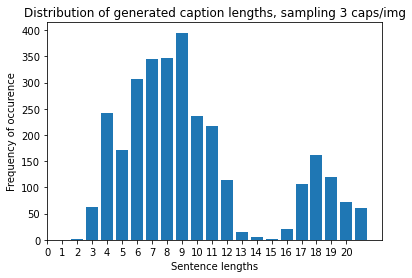

In [24]:
plt.bar(Counter(cap_lens).keys(), Counter(cap_lens).values() )
plt.xlabel("Sentence lengths")
plt.ylabel("Frequency of occurence")
plt.title("Distribution of generated caption lengths, sampling 3 caps/img")
plt.xticks(list(range(0, 21)))
plt.show()

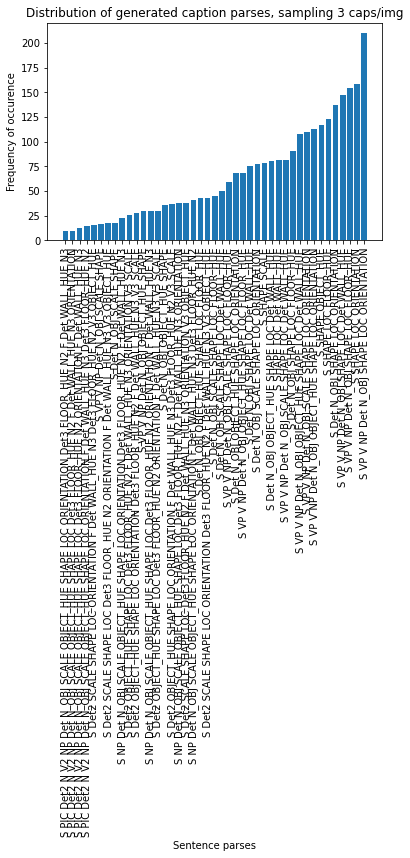

In [25]:
plt.bar(parses_df_ord["parses"], parses_df_ord["counts"] )
plt.xlabel("Sentence parses")
plt.ylabel("Frequency of occurence")
plt.title("Distribution of generated caption parses, sampling 3 caps/img")
plt.xticks(rotation=90)
plt.show()

In [54]:
# compare to distribution of syntactic structures in train dataset
import torch
pretrain_ids = torch.load("../../mSc-thesis/code/src/pretrain_img_IDs_flat_3dshapes_short.pt")

with open("../data/3dshapes_captions_fixed.json", "r") as fp:
    labels_long =  json.load(fp)
 
with open("../data/3dshapes_captions_short_fixed.json", "r") as fp:
    labels_short =  json.load(fp)

train_sentences = []
for i in pretrain_ids:
    short_caps = np.random.choice(labels_short[i], 3)
    long_caps = np.random.choice(labels_long[i], 3) # 3
    train_sentences.extend(short_caps)
    train_sentences.extend(long_caps)

In [96]:
with open("singleton_rules_grammar_exh.txt", 'r') as f:
    base_grammar = f.readlines()
    base_grammar = [s.replace("\n", "").strip() for s in base_grammar] 

with open("singleton_rules_grammar_short.txt", 'r') as f:
    base_grammar_short = f.readlines()
    base_grammar_short = [s.replace("\n", "").strip() for s in base_grammar_short] 

terminals = [list(dict_factor_rules_infer[x].values()) for x in dict_factor_rules_infer.keys()]
terminals_flat = [e for l in terminals for e in l]
terminals_flat = [e for l in terminals_flat for e in l]
# append them to grammar
base_grammar.extend(terminals_flat)
cfg = CFG.fromstring(list(set(base_grammar + base_grammar_short))) 

In [100]:
cfg

<Grammar with 94 productions>

In [102]:
train_sentences_split = [s.lower().split(" ") for s in train_sentences]
print("Number of sentences: ", len(train_sentences_split))
# rd_parser = nltk.RecursiveDescentParser(cfg)

# trees_train = []
# num_unparsed_train = 0
# for s in train_sentences_split:
#     try:
#         for tree in rd_parser.parse(s):
#             trees_train.append(str(tree))
#     except ValueError:
# #         print(s)
#         num_unparsed_train += 1
# print("Number of unparsed sents: ", num_unparsed_train)

# trees_unique_train = list(set(trees_train))
# cleaned_rules_train = []
# for t in trees_train:
#     cleaned_tree = t.replace("(", "").replace(")", "").replace("\n", "").split()
#     cleaned_rule = [c for c in cleaned_tree if c.istitle() or c.isupper()]
#     cleaned_rules_train.append(cleaned_rule)
# print("Cleaned rule occurences", len(cleaned_rules_train))
# cleaned_rules_train_str = [" ".join(s) for s in cleaned_rules_train]
# print("Unique constuctions", len(list(set(cleaned_rules_train_str))))

# parse_counter_train = Counter(cleaned_rules_train_str)
# # sorted(parse_counter.items(), key=lambda pair: pair[1], reverse=True)

# # create a helper df for plotting
# parses_df_train = pd.DataFrame({
#     "parses": parse_counter_train.keys(),
#     "counts": parse_counter_train.values(),
#     "lengths": [len(i.split(" ")) for i in parse_counter_train.keys()]
# })
# parses_df_train_ord = parses_df_train.sort_values("lengths")
# parses_df_train_ord

# count caption lengths on raw sentences
cap_lens_train = [len(i.split(" ")) for i in train_sentences]
cap_lens_counter = sorted(Counter(cap_lens_train).items(), key=lambda pair: pair[0]) 

Number of sentences:  900000


In [103]:
cap_lens_counter

[(3, 30009),
 (4, 33124),
 (5, 52325),
 (6, 68669),
 (7, 58665),
 (8, 68893),
 (9, 68605),
 (10, 31920),
 (11, 28470),
 (12, 8650),
 (13, 670),
 (16, 13034),
 (17, 66118),
 (18, 120557),
 (19, 113594),
 (20, 75753),
 (21, 40976),
 (22, 15883),
 (23, 3728),
 (24, 357)]

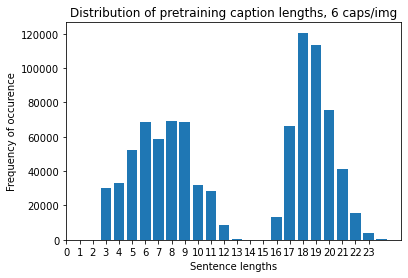

In [104]:
plt.bar(Counter(cap_lens_train).keys(), Counter(cap_lens_train).values() )
plt.xlabel("Sentence lengths")
plt.ylabel("Frequency of occurence")
plt.title("Distribution of pretraining caption lengths, 6 caps/img")
plt.xticks(list(range(0, 24)))
plt.show()

In [ ]:
plt.bar(parses_df_train_ord["parses"], parses_df_train_ord["counts"] )
plt.xlabel("Sentence parses")
plt.ylabel("Frequency of occurence")
plt.title("Distribution of pretraining caption parses, 6 caps/img")
plt.xticks(rotation=90)
plt.show()

## Try embedding an image with the off-the-shelf resnet-50

The code below exracts image features in the exact same way they are extracted on MS COCO. 

In [2]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd

In [13]:
# speaker visual module
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50 for the speaker. 
        Put a linear layer on top, mapping ResNet features to desired visual embedding dimensionality.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer, adding a Linear one
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        """
        Performs a forward step for embedding a batch of images received by the speaker.
        Args:
        -----
            images: torch.tensor((batch_size, 3, 224, 224))
            
        Returns:
        ------
            features: torch.tensor((batch_size, visual_embed_size))
        """
        features = self.resnet(images)
        # reshape features to shape (batch_size, -1)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

In [45]:
# NB: definitely don't use horizontal flip because we might include spatial descriptions


# get some image and put it into (1, 3, 64, 64) torch tensor
example_img = images[1000]
# img_tensor = np.asarray(np.rollaxis(example_img, 2,0))
print("Original image shape: ", example_img.shape)

transform_train = transforms.Compose([ 
    transforms.ToPILImage(),
    # the step below is upsampling the image
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
#     transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
transformed_img = transform_train(example_img)

img_tensor_transormed = transformed_img.unsqueeze(0)
img_tensor_transormed.shape

(64, 64, 3)


torch.Size([1, 3, 224, 224])

In [38]:
transformed_img.size()

torch.Size([3, 224, 224])

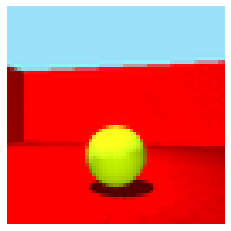

In [46]:
# visualize image before ...
plt.imshow(example_img); plt.axis('off'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


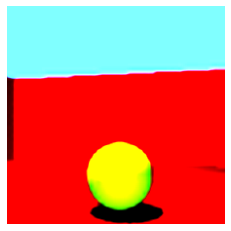

In [47]:
# ... and after transform
plt.imshow(img_tensor_transormed.squeeze(0).permute(1, 2, 0)); plt.axis('off'); plt.show()

In [42]:

encoder = EncoderCNN(1024)
features = encoder(img_tensor_transormed)
features.shape

torch.Size([1, 1024])

### Notes from Hupkes et al compositionality paper
* PCFG construction datset
* simulation such that one feature (like depths) matches in distribution a natural corpus
* PCFG input: unary and binary predicates, string sequence elements, separator
* recursive (inf number of sequences)
* nesting (parse tree can be arbitrarily long)
* naturalization of the dataset through CFG probabilities, input vocab size
* the enforce the following properties in the generated dataset: expression length, parse tree depth
    * naturalization through EM, such that the PCFG generates expressions generating a matching bivariate distribution
* string alphabet size=520, base corpus size = 10.000
* controlling for memorization: never the same string arguments
----

* we need to watch out to not induce any bias in the generated dataset, and to not fail with the evaluation due to some other explanation, like strong compositionality pressure / bias, which cannot be fitted, or something --> like model parsing abilities are going to match Bruni's paper's results here. 
* induce the weights / probs on an NL dataset (we have an inside-outside implementation for Annika and my work)
* the caption lengths distribution should match the one from coco captions, ideally also the rough token distribution
* "productivity" results: none of the architectures could exhibit productive power to unseen sequence lengths! that is, there are grounds to believe that the disciminativity / detail level of the captions will not vary across my two expriments but will remain close to the training lengths!!! it might be worth exploring if that changes if i add an explicit bias to generate short sequences

In [ ]:
# might sample grammatical structures from some corpus and fill them with the labels

## MS COCO preprocessing

* Get the MS COCO split on which the speaker was pretrained. 
* get POS annotations, parse trees

In [3]:
ms_ids = torch.load("../pretrain_img_IDs.pt")

In [4]:
# load annotations from these keys
coco = COCO("../../../data/train/annotations/captions_train2014.json")

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [5]:
# coco.anns.keys()
# get target captions
all_caps = [coco.anns[idx]['caption'] for idx in ms_ids.numpy().tolist()]

In [6]:
all_caps[:5]

['There are many birds flying near the boat. ',
 'Oranges in packaged rope about to be bought or sold',
 'A man with a tennis racket on a tennis court.',
 'A group of small birds on a wooden dock.',
 'A girl trying to open an umbrella while another girl looks at the camera smiling.']

In [7]:
# we can use nltk or stanfordnlp to POS-tag
# import stanfordnlp
from nltk import pos_tag, word_tokenize

In [8]:
pos_list = [pos_tag(word_tokenize(sent)) for sent in all_caps]
len(pos_list)

70000

In [9]:
pos_list_flat = [i for l in pos_list for i in l]

In [10]:
df = pd.DataFrame({"raw_captions": all_caps, "POS": pos_list})
df.head()

,raw_captions,POS
0,There are many birds flying near the boat.,"[(There, EX), (are, VBP), (many, JJ), (birds, ..."
1,Oranges in packaged rope about to be bought or...,"[(Oranges, NNS), (in, IN), (packaged, VBN), (r..."
2,A man with a tennis racket on a tennis court.,"[(A, DT), (man, NN), (with, IN), (a, DT), (ten..."
3,A group of small birds on a wooden dock.,"[(A, DT), (group, NN), (of, IN), (small, JJ), ..."
4,A girl trying to open an umbrella while anothe...,"[(A, DT), (girl, NN), (trying, VBG), (to, TO),..."


In [11]:
def get_pos_str(cap):
    pos_str = " ".join([x[1] for x in cap])
    return pos_str

df["POS_clean"] = df["POS"].apply(get_pos_str)

In [12]:
# df.to_csv("../../../data/ms_coco_pretrain_caps_POS-tagged.csv")
df.head()

,raw_captions,POS,POS_clean
0,There are many birds flying near the boat.,"[(There, EX), (are, VBP), (many, JJ), (birds, ...",EX VBP JJ NNS VBG IN DT NN .
1,Oranges in packaged rope about to be bought or...,"[(Oranges, NNS), (in, IN), (packaged, VBN), (r...",NNS IN VBN NN IN TO VB VBN CC VBN
2,A man with a tennis racket on a tennis court.,"[(A, DT), (man, NN), (with, IN), (a, DT), (ten...",DT NN IN DT NN NN IN DT NN NN .
3,A group of small birds on a wooden dock.,"[(A, DT), (group, NN), (of, IN), (small, JJ), ...",DT NN IN JJ NNS IN DT JJ NN .
4,A girl trying to open an umbrella while anothe...,"[(A, DT), (girl, NN), (trying, VBG), (to, TO),...",DT NN VBG TO VB DT NN IN DT NN VBZ IN DT NN NN .


In [13]:
# get a count of the POS tags
pos_word_counts = Counter(pos_list_flat)
pos_word_counts_desc = sorted(pos_word_counts.items(), key=lambda item: item[1], reverse = True)
# get flat list of POS without words
pos_counts_flat = [x[1] for x in pos_list_flat]
pos_counts_desc = sorted(Counter(pos_counts_flat).items(), key=lambda item: item[1], reverse = True)

In [87]:
print("Number of POS tags used: ", len(pos_counts_desc))
pos_counts_desc[:10]

Number of POS tags used:  43


[('NN', 210187),
 ('DT', 150001),
 ('IN', 116613),
 ('JJ', 58254),
 ('.', 52562),
 ('NNS', 42775),
 ('VBG', 42265),
 ('VBZ', 19144),
 ('CC', 16751),
 ('NNP', 9616)]

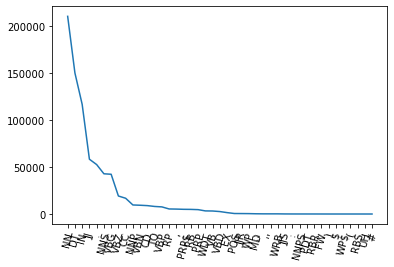

In [80]:
# plot counts of tag occurences
plt.plot([x[0] for x in pos_counts_desc], [x[1] for x in pos_counts_desc])
plt.xticks(rotation=75)
plt.show()

In [14]:
# count the distinct syntactic structures:
pos_strings_count = sorted(Counter(df["POS_clean"]).items(), key=lambda item: item[1], reverse = True)
print("Number of unique syntactic structures: ", len(pos_strings_count))
pos_strings_count[:10]

Number of unique syntactic structures:  51517


[('DT NN VBG IN DT NN IN DT NN .', 158),
 ('DT NN VBG DT NN IN DT NN .', 144),
 ('DT NN WDT VBZ VBG IN DT NN .', 135),
 ('DT NN IN DT NN IN DT NN .', 128),
 ('DT NN VBZ VBG IN DT NN IN DT NN .', 105),
 ('DT NN VBZ VBG DT NN IN DT NN .', 103),
 ('DT NN IN NNS VBG IN DT NN .', 91),
 ('DT JJ NN IN DT NN IN DT NN .', 84),
 ('DT NN VBG DT NN NN IN DT NN .', 72),
 ('DT NN VBZ VBG IN DT JJ NN .', 72)]

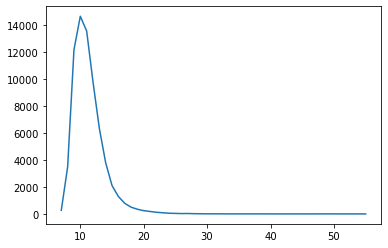

In [15]:
# explore average sentence length (not quite parse tree depth, but also important)
pos_lengths = [len(lst) for lst in pos_list]
pos_lengths_counter = sorted(Counter(pos_lengths).items(), key=lambda item: item[0], reverse = False)

# plot lengths distribution
plt.plot([x[0] for x in pos_lengths_counter], [x[1] for x in pos_lengths_counter])
# plt.xticks(rotation=75)
plt.show()

In [21]:
import stanza # https://stanfordnlp.github.io/stanza/depparse.html

nlp = stanza.Pipeline('en', processors='depparse,tokenize, mwt, pos, lemma')

2022-04-26 22:26:19 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-04-26 22:26:19 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-04-26 22:26:19 INFO: Use device: cpu
2022-04-26 22:26:19 INFO: Loading: tokenize
2022-04-26 22:26:19 INFO: Loading: pos
2022-04-26 22:26:20 INFO: Loading: lemma
2022-04-26 22:26:20 INFO: Loading: depparse
2022-04-26 22:26:20 INFO: Done loading processors!


In [30]:
# parse an example sentence
parsed_sents = nlp(all_caps[0])

In [31]:
parsed_sents.sentences[0].words

[{
   "id": 1,
   "text": "There",
   "lemma": "there",
   "upos": "PRON",
   "xpos": "EX",
   "head": 2,
   "deprel": "expl",
   "start_char": 0,
   "end_char": 5
 },
 {
   "id": 2,
   "text": "are",
   "lemma": "be",
   "upos": "VERB",
   "xpos": "VBP",
   "feats": "Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin",
   "head": 0,
   "deprel": "root",
   "start_char": 6,
   "end_char": 9
 },
 {
   "id": 3,
   "text": "many",
   "lemma": "many",
   "upos": "ADJ",
   "xpos": "JJ",
   "feats": "Degree=Pos",
   "head": 4,
   "deprel": "amod",
   "start_char": 10,
   "end_char": 14
 },
 {
   "id": 4,
   "text": "birds",
   "lemma": "bird",
   "upos": "NOUN",
   "xpos": "NNS",
   "feats": "Number=Plur",
   "head": 2,
   "deprel": "nsubj",
   "start_char": 15,
   "end_char": 20
 },
 {
   "id": 5,
   "text": "flying",
   "lemma": "fly",
   "upos": "VERB",
   "xpos": "VBG",
   "feats": "VerbForm=Ger",
   "head": 4,
   "deprel": "acl",
   "start_char": 21,
   "end_char": 27
 },
 {
   "id":

In [27]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in parsed_sents.sentences for word in sent.words], sep='\n')

id: 1	word: There	head id: 2	head: are	deprel: expl
id: 2	word: are	head id: 0	head: root	deprel: root
id: 3	word: many	head id: 4	head: birds	deprel: amod
id: 4	word: birds	head id: 2	head: are	deprel: nsubj
id: 5	word: flying	head id: 4	head: birds	deprel: acl
id: 6	word: near	head id: 8	head: boat	deprel: case
id: 7	word: the	head id: 8	head: boat	deprel: det
id: 8	word: boat	head id: 5	head: flying	deprel: obl
id: 9	word: .	head id: 2	head: are	deprel: punct
